In [1]:
import pandas as pd
import finterstellar as fs

In [2]:
coin = fs.CoinPrice()

In [3]:
cd = 'BTC'

In [4]:
coin_df = coin.bithumb_historical_price(coin_cd=cd, freq='M')
coin_df.head()

,close,open,high,low,volume
2019-04-20 16:36:00,6135000.0,6133000.0,6135000.0,6133000.0,4.7329
2019-04-20 16:37:00,6136000.0,6132000.0,6136000.0,6132000.0,0.6408
2019-04-20 16:38:00,6139000.0,6136000.0,6139000.0,6133000.0,5.1251
2019-04-20 16:39:00,6133000.0,6139000.0,6139000.0,6133000.0,4.2368
2019-04-20 16:40:00,6139000.0,6139000.0,6139000.0,6139000.0,0.0048


In [5]:
trd = fs.SingleAsset()   # fs 라이브러리의 SingleAsset 모듈을 불러와 trd에 로딩

base_date = '2019-04-21 09:00:00'   # 기준일자 설정

In [6]:
df = pd.DataFrame()    # 빈 데이터프레임을 생성하고
df[cd] = coin_df['close'].copy()    # 시세를 복사해 넣음
df['volume'] = coin_df['volume'].copy()    # 거래량도 복사해 넣음
df = df.dropna()     # na를 없애고
df.head(3)

,BTC,volume
2019-04-20 16:36:00,6135000.0,4.7329
2019-04-20 16:37:00,6136000.0,0.6408
2019-04-20 16:38:00,6139000.0,5.1251


In [7]:
n = 20     # 평균주가계산 기준일수
sigma = 2     # 편차구간 지정 (시그마의 배수로)

In [8]:
# 볼린저밴드 계산
bb = trd.bollinger_band(df, cd, n, sigma)
# bollinger_band(데이터프레임, 분석대상코드, 평균기준일, 편차구간) - 볼린저밴드 분석값 계산
bb.tail()

,BTC,center,ub,lb,band_size
2019-04-21 16:30:00,6167000.0,6166650.0,6.169186e+06,6.164114e+06,5072.111571
2019-04-21 16:31:00,6168000.0,6166700.0,6.169304e+06,6.164096e+06,5207.282350
2019-04-21 16:32:00,6168000.0,6166650.0,6.169102e+06,6.164198e+06,4903.274953
2019-04-21 16:33:00,6167000.0,6166650.0,6.169102e+06,6.164198e+06,4903.274953
2019-04-21 16:35:00,6169000.0,6166800.0,6.169444e+06,6.164156e+06,5287.522552


In [9]:
# 샘플링
sample = bb.loc[base_date:]     # 계산 결과를 기준일자 이후만 잘라내 sample 데이터프레임에 저장
sample.head()

,BTC,center,ub,lb,band_size
2019-04-21 09:00:00,6142000.0,6145100.0,6.152884e+06,6.137316e+06,15567.848109
2019-04-21 09:01:00,6143000.0,6145250.0,6.152730e+06,6.137770e+06,14959.594703
2019-04-21 09:02:00,6143000.0,6144950.0,6.152276e+06,6.137624e+06,14652.465214
2019-04-21 09:03:00,6144000.0,6145200.0,6.151993e+06,6.138407e+06,13586.370880
2019-04-21 09:05:00,6145000.0,6145150.0,6.151933e+06,6.138367e+06,13566.211898


In [10]:
book = trd.create_trade_book(sample, cd)
# create_trade_book(데이터프레임, [종목코드]) - 트레이딩북 생성
book.head()

,BTC,t BTC,p BTC
2019-04-21 09:00:00,6142000.0,,
2019-04-21 09:01:00,6143000.0,,
2019-04-21 09:02:00,6143000.0,,
2019-04-21 09:03:00,6144000.0,,
2019-04-21 09:05:00,6145000.0,,


In [11]:
# 트레이딩 전략 설정
thd = 'ub'   # 종목 매도 기준 (편차구간상단:ub, 편차구간중심:center)
buy = 'out'    # 종목 매수 기준 (편차구간 진입 시:in, 편차구간 벗어날 시:out)
book = trd.tradings(sample, book, thd, cd, buy, short=False)
# tradings(데이터프레임, 트레이딩북, 매도기준, 종목코드, 매입기준) - 매매전략을 이용한 백테스팅 수행

In [12]:
# 포지션 계산
book = trd.position(book, cd)
# position(트레이딩북, 종목코드) - 트레이딩 전략 수행에 수반되는 포지션 판단
'''
    z : zero
    l : long
    s : short
    zz : zero to zero
    zl : zero to long
    lz : long to zero
'''
book.head()

,BTC,t BTC,p BTC
2019-04-21 09:00:00,6142000.0,,zz
2019-04-21 09:01:00,6143000.0,,zz
2019-04-21 09:02:00,6143000.0,,zz
2019-04-21 09:03:00,6144000.0,,zz
2019-04-21 09:05:00,6145000.0,,zz


In [13]:
# 수익률 계산
fund_rtn = trd.returns(book, cd, display=True)
# returns(트레이딩북, 종목코드) - 전략의 수익률 계산

2019-04-21 09:36:00 long BTC 6154000.0
2019-04-21 11:57:00 long BTC 6154000.0  | unwind long BTC 6169000.0  | return: 1.0024
2019-04-21 13:07:00 long BTC 6165000.0
2019-04-21 14:00:00 long BTC 6165000.0  | unwind long BTC 6165000.0  | return: 1.0
2019-04-21 14:40:00 long BTC 6160000.0
2019-04-21 15:39:00 long BTC 6160000.0  | unwind long BTC 6155000.0  | return: 0.9992
Accumulated return: 0.16 %  ( # of trade: 3  , # of win: 1  )
Avg return: 0.0005 , Prob. of win: 0.3333


In [14]:
# 벤치마크 수익률
bm_rtn = trd.benchmark_return(book, cd)
# benchmark_return(트레이딩북, 종목코드) - 벤치마크 수익률 계산

BM return: 0.44 %
{'BTC': 1.0044}


In [15]:
# 초과 수익률
exs_rtn = trd.excess_return(fund_rtn, bm_rtn)
# excess_return(전략수익률, 벤치마크수익률) - 초과수익률 계산

Excess return: -0.28 %


그래프로 표현하기

In [16]:
v = fs.VisualizeIntraday()    # fs 라이브러리의 Visualize() 모듈을 불러와 v로 지정

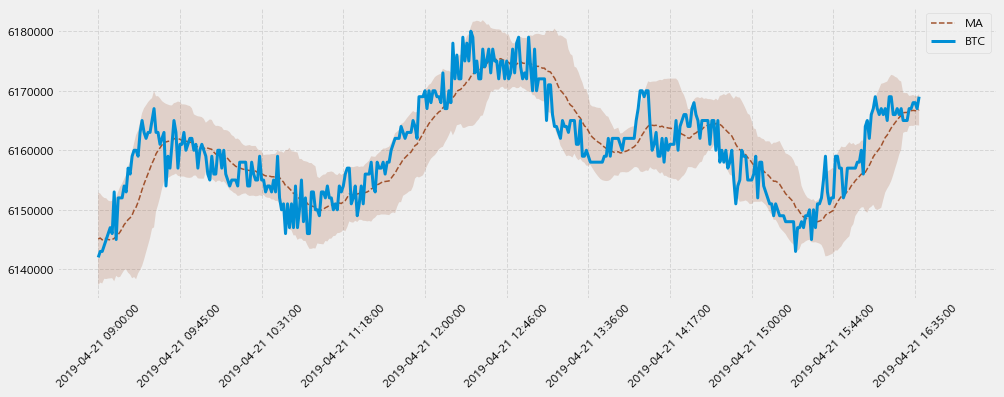

In [17]:
v.bb_trend_view(sample, sigma, cd, size=(15,5))
# v 모듈의 bb_trend_view(데이터프레임, 편차구간, 종목코드, (사이즈)) 함수 - 볼린저밴드 그래프 그리기

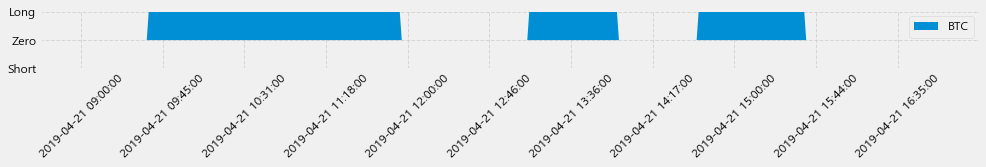

In [18]:
v.position_view(book, cd)
# v 모듈의 position_view(트레이딩북, 종목코드, (사이즈)) 함수 - 보유내역 그래프 그리기

최근 전략

In [19]:
#last_date = sample.index[-1].date().strftime('%Y-%m-%d')
last_point = sample.index[-1]
# 현재 투자전략 추출을 위해 데이터 상 최종일 추출
last_point

'2019-04-21 16:35:00'

In [20]:
trd.trading_strategy(sample, thd, cd, last_point)
# trading_strategy(데이터프레임, 매도기준, 종목코드, 최종일) - 트레이딩 전략 판단

As of 2019-04-21 16:35:00 this model suggests you to just wait


'just wait'

In [21]:
trd.position_strategy(book, cd, last_point)
# position_strategy(트레이딩북, 종목코드 최종일) - 포지션 구축 전략 판단

As of 2019-04-21 16:35:00 your model portfolio ['BTC'] needs to be composed of nothing


'nothing'

백테스팅 결과인 트레이딩북을 한번 구경해볼까요?

In [22]:
book[-50:]

,BTC,t BTC,p BTC,return,acc return,psBTC
2019-04-21 15:37:00,6152000.0,buy,ll,1.000000,1.002437,1
2019-04-21 15:39:00,6155000.0,,lz,0.999188,1.001624,0
2019-04-21 15:40:00,6159000.0,,zz,1.000000,1.001624,0
2019-04-21 15:41:00,6153000.0,,zz,1.000000,1.001624,0
2019-04-21 15:42:00,6151000.0,,zz,1.000000,1.001624,0
2019-04-21 15:43:00,6152000.0,,zz,1.000000,1.001624,0
2019-04-21 15:44:00,6152000.0,,zz,1.000000,1.001624,0
2019-04-21 15:45:00,6159000.0,,zz,1.000000,1.001624,0
2019-04-21 15:46:00,6159000.0,,zz,1.000000,1.001624,0
2019-04-21 15:47:00,6157000.0,,zz,1.000000,1.001624,0
